In [1]:
import xarray as xr
from xgcm import Grid
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
#import cmocean.cm as cmo
%matplotlib inline

In [2]:
chunks = {'ocean_time':1}

ds = xr.open_dataset('outer_avg.nc', chunks=chunks)

## Creating a grid object

In [3]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

In [4]:
ds

<xarray.Dataset>
Dimensions:         (boundary: 4, eta_rho: 317, eta_v: 316, ocean_time: 1, s_rho: 30, s_w: 31, tracer: 2, xi_rho: 272, xi_u: 271)
Coordinates: (12/13)
  * s_rho           (s_rho) float64 -0.9715 -0.9156 ... -0.0156 -0.004799
  * s_w             (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u           (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u           (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    ...              ...
    lat_v           (eta_v, xi_rho) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
    lon_psi         (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_psi         (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
  * ocean_time      (ocean_time) datetime64[ns] 2005-05-17T12:00:00
    z_w             (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    z_rho           (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 317, 272), meta=np.ndarray>
Dimensions without coordinates: boundary, eta_rho, eta_v, tracer, xi_rho, xi_u
Data variables: (12/126)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    nHIS            int32 ...
    ...              ...
    dz_w            (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 1, 317, 272), meta=np.ndarray>
    dz_u            (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 317, 271), meta=np.ndarray>
    dz_w_u          (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 1, 317, 271), meta=np.ndarray>
    dz_v            (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 316, 272), meta=np.ndarray>
    dz_w_v          (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 1, 316, 272), meta=np.ndarray>
    dA              (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
Attributes: (12/35)
    file:              outer_avg.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           Tue Jan 26 20:16:36 2021: ncra -O -n 277,5,30 outer_av...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...
    NCO:               netCDF Operators version 4.9.2 (Homepage = http://nco....

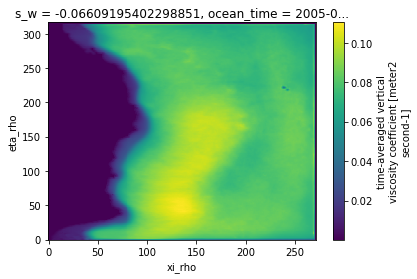

In [86]:
ds.AKv[0,25,:,:].plot()

In [34]:
# Calculate div (ubar / h)
ubar = ds.ubar[0,:,:]
vbar = ds.vbar[0,:,:]
ds['hr_onU'] = grid.interp(1 / ds.h, 'X') #keep_coords=True ??
ds['hr_onV'] = grid.interp(1 / ds.h, 'Y')
flux_u = ds.hr_onU * ubar * ds.dy_u  # (i-1/2, j)
flux_v = ds.hr_onV * vbar * ds.dx_v  # (i, j-1/2)
#divg_ubar_div_h = (flux_u.shift(xi_u=-1) - flux_u + flux_v.shift(eta_v=-1) - flux_v) / ds.dA
divg_ubar_div_h = (grid.diff(flux_u, 'X', boundary='extend') + grid.diff(flux_v, 'Y', boundary='extend')) / ds.dA

(-38.0, -25.091913468410358)

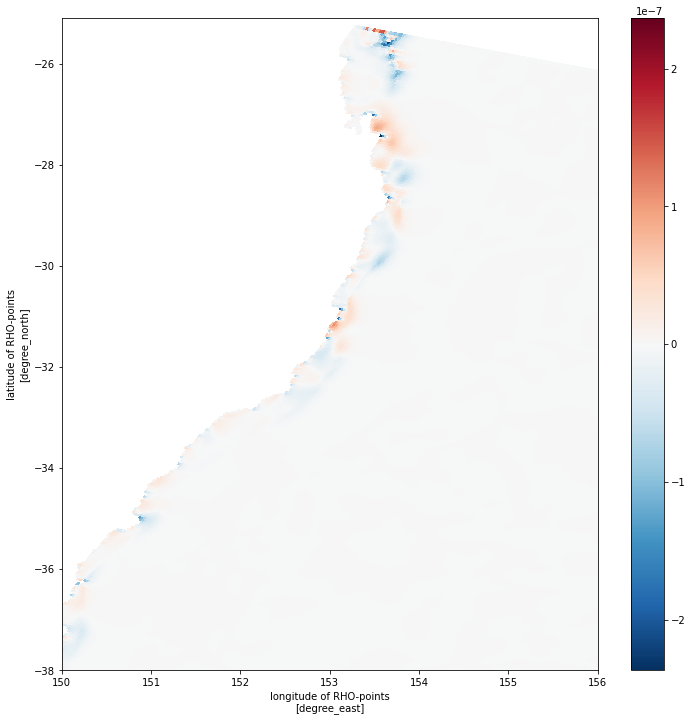

In [35]:
fig = plt.figure(figsize=(12,12))
divg_ubar_div_h.plot(x='lon_rho', y='lat_rho')
plt.xlim(150, 156)
plt.ylim(-38, None)

$|\nabla h^{-1}|^2 = (\partial_x h^{-1})^2 + (\partial_y h^{-1})^2$

In [25]:
# one option to get started.  Seems to give problems at north and south boundary of domain where topography
# is very smooth.  Maybe try fitting a plane to 5 bathymetric data points surrounding a central point, and use that
# plane to get the slope...?
ds['hr_6x'] = (grid.diff(ds.h, 'X') / ds.dx_u) ** 2
ds['hr_6y'] = (grid.diff(ds.h, 'Y') / ds.dy_v) ** 2
ds['hr_grad'] = np.sqrt(grid.interp(ds.hr_6x, 'X', boundary='extend') + grid.interp(ds.hr_6y, 'Y', boundary='extend'))

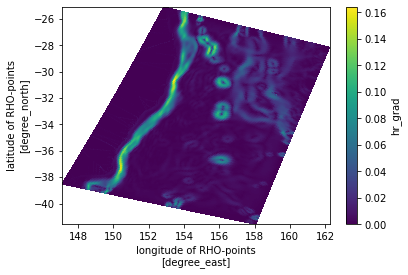

In [27]:
ds.hr_grad.plot(x='lon_rho', y='lat_rho')

In [37]:
x_shelf_transport = - divg_ubar_div_h / ds.hr_grad

(147.07391730247966, 155.0)

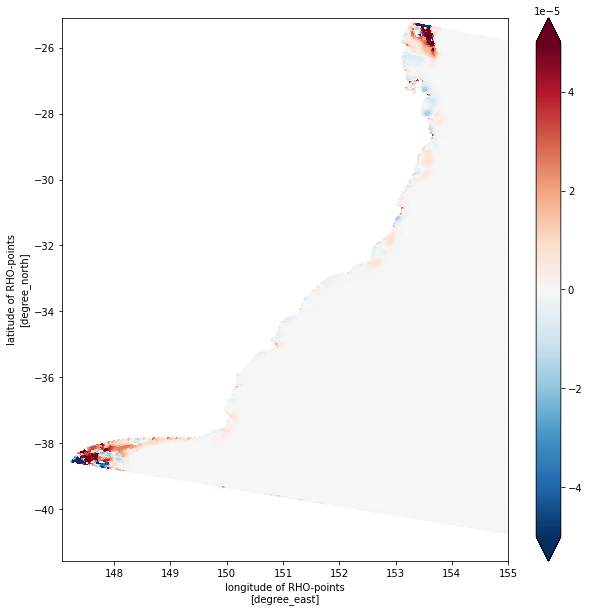

In [50]:
fig = plt.figure(figsize=(10,10))
x_shelf_transport.plot(vmin=-5e-5, x='lon_rho', y='lat_rho')
plt.xlim(None, 155)

In [55]:
ds.theta_b.values

array(5.)